In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable 
from torch.utils import data
import torchvision.transforms.functional as TF

import h5py 
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

import torchvision.transforms as transforms


class ConEncoder(nn.Module):
    def __init__(self, input_dim, middle_dim, hidden_dim, z_dim):
        super().__init__()
        
        self.model_conv = nn.Sequential(
            nn.Conv2d(in_channels=input_dim, out_channels=int(middle_dim/2), kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(int(middle_dim/2)),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Conv2d(in_channels=int(middle_dim/2), out_channels=middle_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(middle_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Conv2d(in_channels=middle_dim, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10)
        )

        self.fc_mu = nn.Linear(hidden_dim * 12 * 8, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 12 * 8, z_dim)

    def forward(self, x):
        x = self.model_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class LSTMDecoder(nn.Module):
    def __init__(self, z_dim, middle_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.model_linear = nn.Sequential(
            
            nn.Linear(z_dim, int(middle_dim/2)),
            nn.BatchNorm1d(int(middle_dim/2)),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(int(middle_dim/2), middle_dim),
            nn.BatchNorm1d(middle_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10)
        )

        self.lstm = nn.LSTM(z_dim, hidden_dim*hidden_dim, batch_first=True)

        self.model_conv = nn.Sequential(
            
            nn.ConvTranspose2d(1,1,stride=4, kernel_size=8, padding=2, output_padding=0, dilation=1),
            nn.BatchNorm2d(1),
            #nn.LeakyReLU(),
            nn.Dropout(0.10),
            #nn.ConvTranspose2d(1,1,stride=2, kernel_size=5),
            #nn.BatchNorm2d(1),
            #nn.LeakyReLU(),
            #nn.Dropout(0.10),
            #nn.ConvTranspose2d(1,1,stride=2, kernel_size=3),
            #nn.BatchNorm2d(1),
            #nn.LeakyReLU(),
            #nn.Dropout(0.10),
            #nn.ConvTranspose2d(1,1,stride=2, kernel_size=4),
            #nn.BatchNorm2d(1)
        )

        #self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, hidden):
        #x, hidden = self.lstm(z, hidden)
        #x = self.fc(x)
        #print(z)
        #x = self.model_linear(z)
        x, hidden = self.lstm(z, hidden)
        #print(x.shape)
        x = torch.reshape(x, (-1,1,30,30))
        x = self.model_conv(x)
        #print(x.shape)
        return self.sigmoid(x), hidden

class LDecoder(nn.Module):
    def __init__(self, z_dim, middle_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.model_linear = nn.Sequential(
            nn.Linear(z_dim, middle_dim),
            nn.BatchNorm1d(middle_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(middle_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(hidden_dim, 16*24),
            nn.BatchNorm1d(16*24),
            nn.LeakyReLU(),
            nn.Dropout(0.10)
        )

        #self.lstm = nn.LSTM(z_dim, hidden_dim*hidden_dim, batch_first=True)

        self.model_conv = nn.Sequential(
            
            #nn.ConvTranspose2d(1,1,stride=2, kernel_size=4, padding=1, output_padding=0, dilation=1),
            #nn.BatchNorm2d(1),
            #nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.ConvTranspose2d(1,4,stride=2, kernel_size=4, padding=1, output_padding=0, dilation=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
            nn.Dropout2d(0.10),
            nn.ConvTranspose2d(4,2,stride=2, kernel_size=4, padding=1, output_padding=0, dilation=1),
            nn.BatchNorm2d(2),
            nn.Dropout2d(0.10),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

        #self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        #x, hidden = self.lstm(z, hidden)
        #x = self.fc(x)
        #print(z)
        x = self.model_linear(z)
        #x, hidden = self.lstm(z, hidden)
        #print(x.shape)
        x = torch.reshape(x, (-1,1,24,16))
        x = self.model_conv(x)
        #print(x.shape)
        return self.sigmoid(x)

class LinDecoder(nn.Module):
    def __init__(self, z_dim, middle_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.model_linear = nn.Sequential(
            nn.Linear(z_dim, middle_dim),
            nn.BatchNorm1d(middle_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(middle_dim, 16*24),
            nn.BatchNorm1d(16*24),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(16*24, 16*48),
            nn.BatchNorm1d(16*48),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(16*48, 32*48),
            nn.BatchNorm1d(32*48),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(32*48, 32*96),
            nn.BatchNorm1d(32*96),
            nn.LeakyReLU(),
            nn.Dropout(0.10),
            nn.Linear(32*96, 64*96),
            nn.BatchNorm1d(64*96),
            nn.Dropout(0.10)
        )

        #self.lstm = nn.LSTM(z_dim, hidden_dim*hidden_dim, batch_first=True)

        self.model_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

        #self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        #x, hidden = self.lstm(z, hidden)
        #x = self.fc(x)
        #print(z)
        x = self.model_linear(z)
        #x, hidden = self.lstm(z, hidden)
        #print(x.shape)
        x = torch.reshape(x, (-1,1,96,64))
        x = self.model_conv(x)
        #print(x.shape)
        return self.sigmoid(x)

class VAE(nn.Module):
    def __init__(self, input_dim, middle_dim, hidden_dim, z_dim, output_dim):
        super().__init__()
        
        self.encoder = ConEncoder(input_dim, middle_dim, hidden_dim, z_dim)
        self.decoder = LinDecoder(z_dim, middle_dim, hidden_dim, output_dim)
        
    def forward(self, x, hidden=None):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        #print(z, z.shape)
        #x_recon, hidden = self.decoder(z.unsqueeze(1), hidden)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

input_dim = 1
middle_dim = 24*2
hidden_dim = 30
z_dim = 16*2
output_dim = 96*64

model = VAE(input_dim,middle_dim, hidden_dim, z_dim, output_dim)


In [2]:
def loss_fn(x_recon, x, mu, logvar):
    #print('this',x.shape, x_recon.shape)
    #print(x,x_recon)
    recon_loss = F.binary_cross_entropy(x_recon.view(-1, output_dim), x.view(-1, output_dim), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    #kl_loss = torch.mean(-0.5*torch.sum(1+logvar - mu**2 - logvar.exp(), dim=1), dim = 0)
    return recon_loss + 10*kl_loss, recon_loss, kl_loss

def train(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    train_rloss, train_kloss = 0,0
    for x, c in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        loss, rloss, kloss = loss_fn(x_recon, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_rloss += rloss.item()
        train_kloss += kloss.item()
        optimizer.step()
    return train_loss / len(dataloader.dataset), train_rloss / len(dataloader.dataset), train_kloss / len(dataloader.dataset)

def validate(model, dataloader, device):
    model.eval()
    val_loss = 0
    val_rloss, val_kloss = 0, 0
    with torch.no_grad():
        for x, c in dataloader:
            x = x.to(device)
            x_recon, mu, logvar = model(x)
            loss, rloss, kloss = loss_fn(x_recon, x, mu, logvar)#.item()
            val_loss += loss.item()
            val_rloss += rloss.item()
            val_kloss += kloss.item()
    return val_loss / len(dataloader.dataset), val_rloss / len(dataloader.dataset), val_kloss / len(dataloader.dataset)

def train_vae(model, train_dataloader, val_dataloader, num_epochs, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=1e-4, capturable=True)

    trainl, trainrl, trainkl, vall, valrl, valkl = [], [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_rloss, train_kloss = train(model, train_dataloader, optimizer, device)
        val_loss, val_rloss, val_kloss = validate(model, val_dataloader, device)
        trainl += [train_loss]
        trainrl += [train_rloss]
        trainkl += [train_kloss]
        vall += [val_loss]
        valrl += [val_rloss]
        valkl += [val_kloss]
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        img = trainset[0][0].unsqueeze(0).to(device)
        #lb = torch.tensor([trainset[0][1]]).to(device)
        model.eval()
        with torch.no_grad():
            rec_img, _, _  = model.forward(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(model.state_dict(), 'model_params.pth')
        #torch.save(decoder.state_dict(), 'decoder_params.pth')
    return trainl, trainrl, trainkl, vall, valrl, valkl


In [3]:
class Normalize(transforms.Normalize):
    def __init__(self, feature_min, feature_max):
        self.min = torch.tensor(feature_min, dtype=torch.float32)
        self.range = torch.tensor(feature_max, dtype=torch.float32) - self.min

    def __call__(self, tensor):
        return (tensor - self.min) / self.range

class RotationTransform():
    """Rotate by 90 degrees."""

    def __init__(self):
        self.angle = 90

    def __call__(self, x):
        return TF.rotate(x, self.angle)

In [4]:
class HDF5Dataset(Dataset):

    transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(4538.7563,7507.9136),
        #RotationTransform()
        #transforms.Normalize((0.5), (0.5))
    ])
                   
    def __init__(self, h5_path):
        self.h5_path = h5_path #'/content/processed_data_pp.h5'
        f = h5py.File(h5_path, 'r')
        self.mDoppler = f['mDoppler'][:,:,:]
        #self.rdn = f['rdn']
        self.label = np.array(f['labels'], dtype='str')
        self.length = len(self.label)
        self.labels_dict = {'fall on floor of room': 0, 'get in  bed': 1,
                   'get out  bed': 2, 'lie in bed': 3,
                   'roll in bed': 4, 'sit down on bed': 5,
                   'sit down on chair': 6, 'sit in bed': 7,
                   'stand up from bed': 8, 'stand up from chair': 9,
                   'stand up from floor of room': 10, 'walk to bed': 11,
                   'walk to chair': 12, 'walk to room': 13}

    def __getitem__(self, index): #to enable indexing
        doppler = self.mDoppler[index]
        #radar = self.rdn[index]
        label = self.label[index]
        numerical_label = self.labels_dict[label]

        # transform to PIL image
        #image = Image.fromarray(pixels.astype('uint8'), 'RGB') # assume your data is  uint8 rgb

        # transformation here
        # torchvision PIL transformations accepts one image as input
        #radar = self.transform(radar).astype(np.uint8)
        doppler = np.float32(doppler)
        doppler = self.transform(doppler)#.astype(np.uint8))
        return (
                #radar,
                doppler,
               # label,
                numerical_label
        )

    def __len__(self):
        return self.length

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
all_set = HDF5Dataset('/content/drive/MyDrive/PatientActivityRecognition/all_new_data_wrap.h5')
trainset, valset, testset = torch.utils.data.random_split(all_set, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))
train_dataloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=50)
val_dataloader = torch.utils.data.DataLoader(valset, shuffle=True, batch_size=50)
#testset = HDF5Dataset('/content/drive/MyDrive/PatientActivityRecognition/all_new_data_wrap.h5')
#test_dataloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=50)

Epoch 1/50, Train Loss: 4871.9815, Validation Loss: 4258.0563


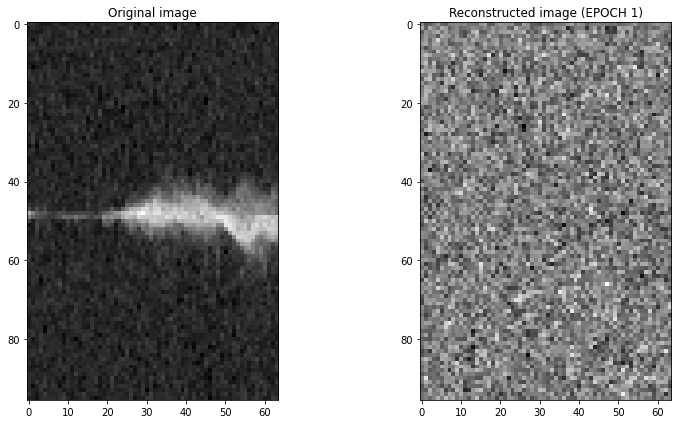

Epoch 2/50, Train Loss: 4453.7688, Validation Loss: 4294.2862


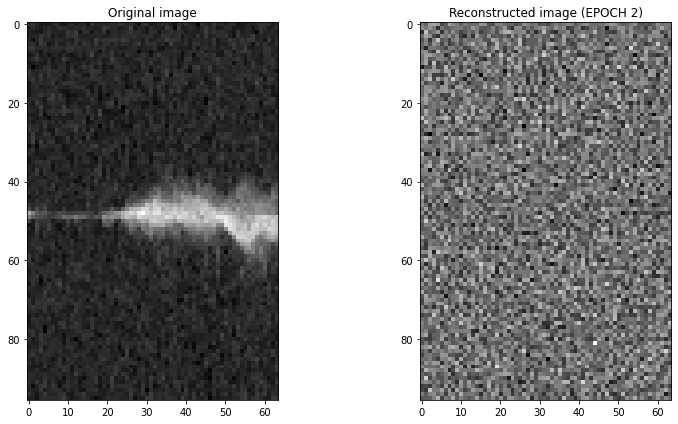

Epoch 3/50, Train Loss: 4325.9208, Validation Loss: 4109.8591


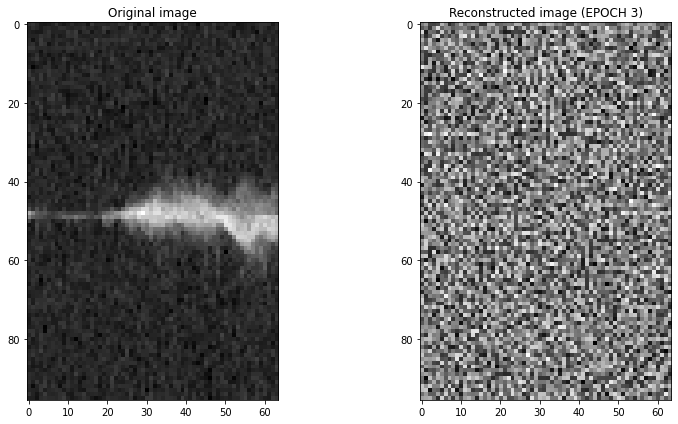

Epoch 4/50, Train Loss: 4223.6026, Validation Loss: 4111.1734


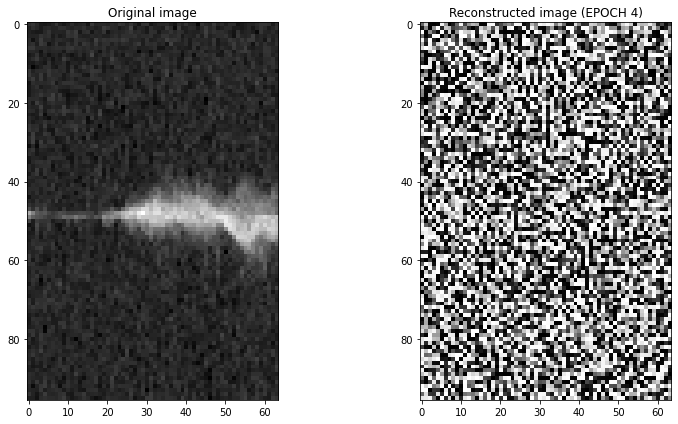

Epoch 5/50, Train Loss: 4137.4749, Validation Loss: 4281.6054


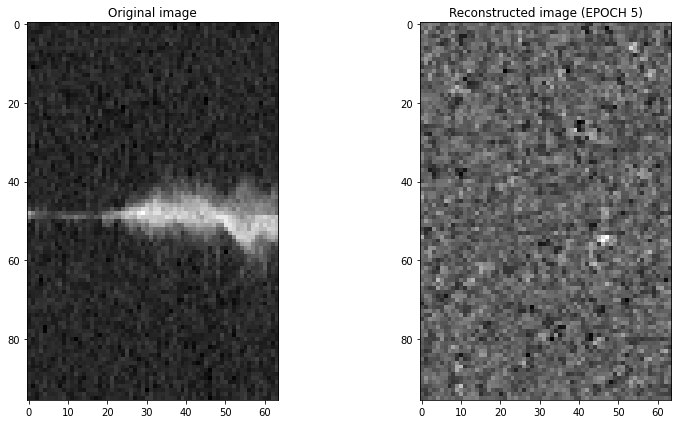

Epoch 6/50, Train Loss: 4059.5524, Validation Loss: 4060.0476


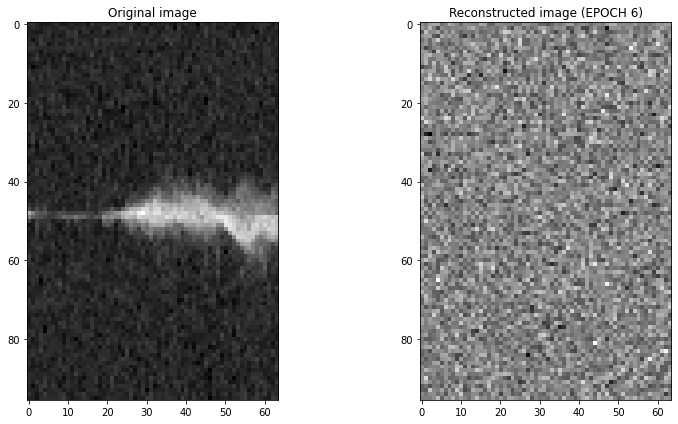

Epoch 7/50, Train Loss: 3986.0719, Validation Loss: 4009.1415


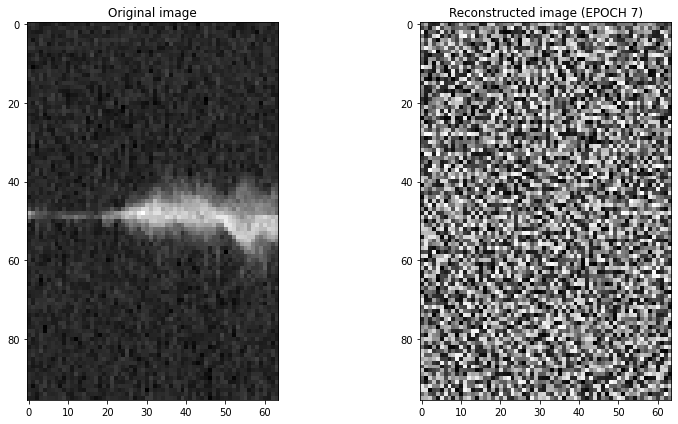

Epoch 8/50, Train Loss: 3899.1681, Validation Loss: 3977.0965


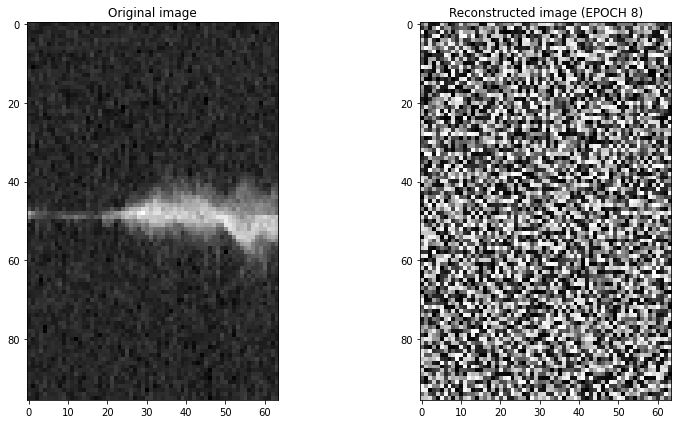

Epoch 9/50, Train Loss: 3829.3025, Validation Loss: 4070.3530


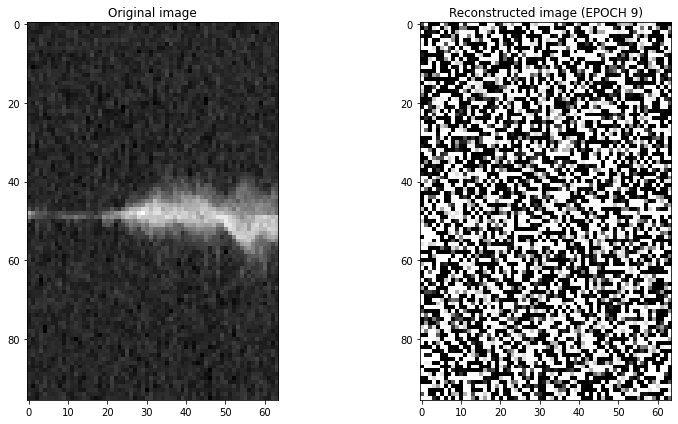

Epoch 10/50, Train Loss: 3749.5594, Validation Loss: 3663.8079


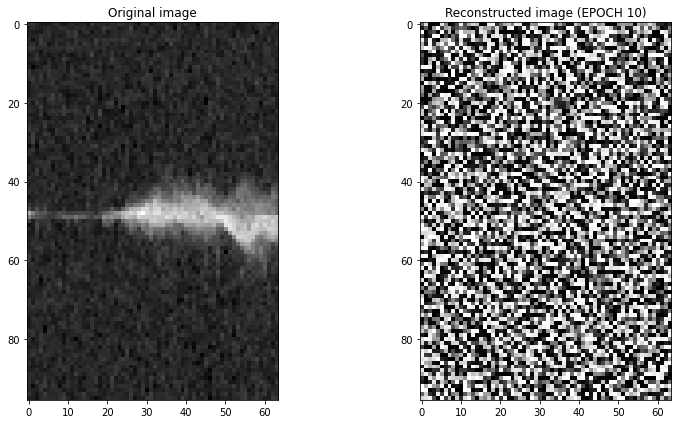

Epoch 11/50, Train Loss: 3670.1776, Validation Loss: 3584.2776


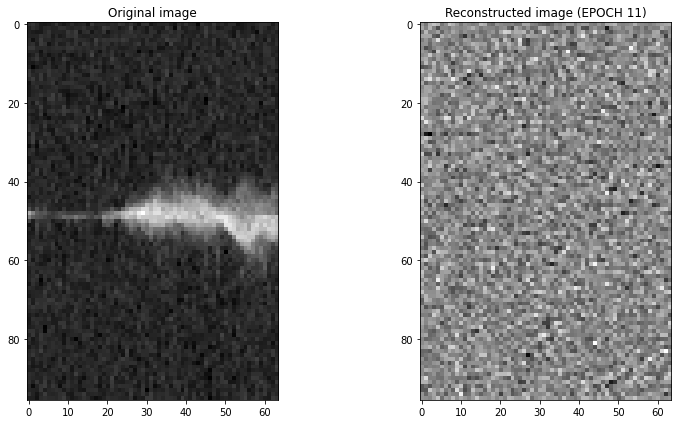

Epoch 12/50, Train Loss: 3598.3249, Validation Loss: 3631.3928


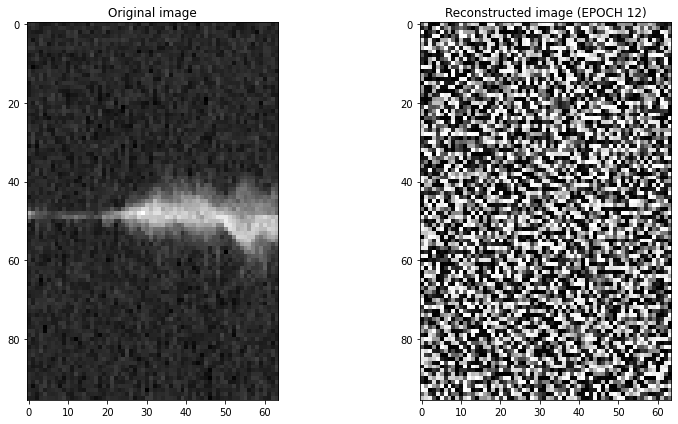

Epoch 13/50, Train Loss: 3521.6283, Validation Loss: 3461.5540


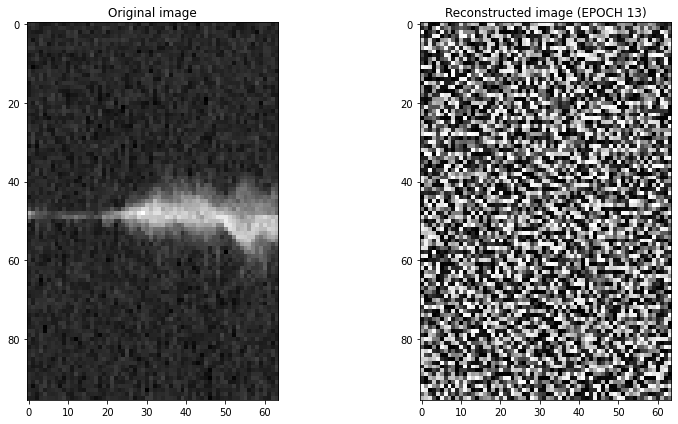

Epoch 14/50, Train Loss: 3444.1262, Validation Loss: 3446.5383


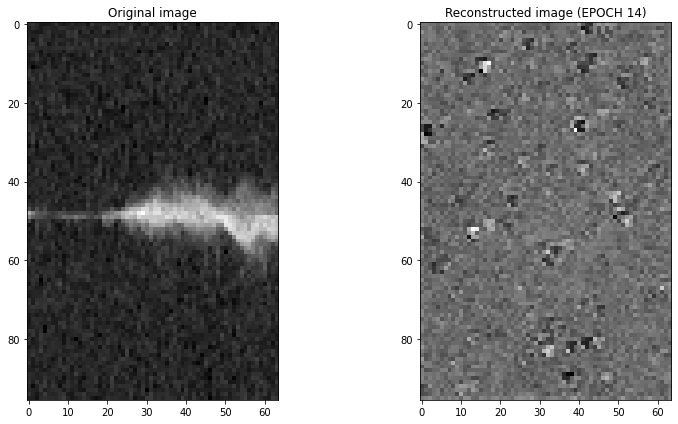

Epoch 15/50, Train Loss: 3358.2834, Validation Loss: 3365.5884


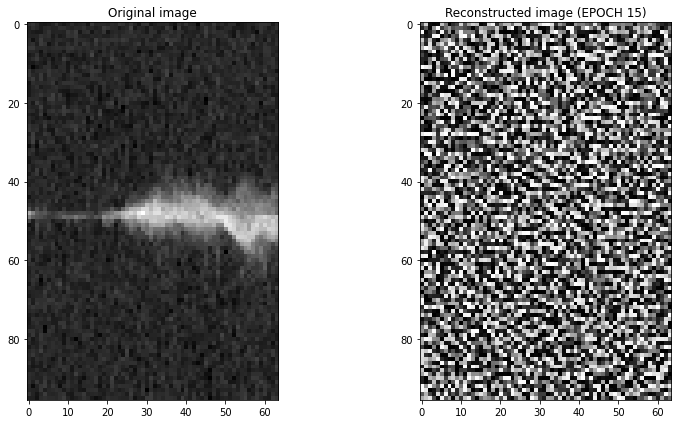

Epoch 16/50, Train Loss: 3287.0515, Validation Loss: 3378.7840


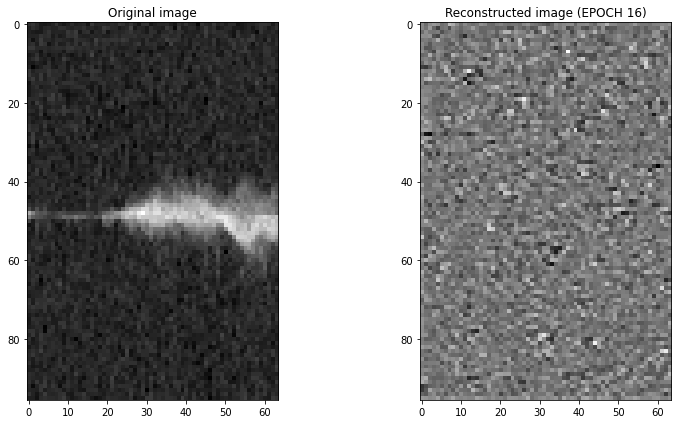

Epoch 17/50, Train Loss: 3202.6048, Validation Loss: 3199.8548


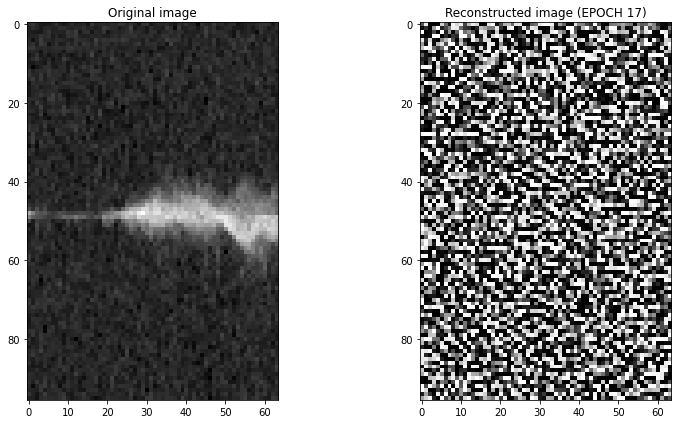

Epoch 18/50, Train Loss: 3128.4526, Validation Loss: 3227.8385


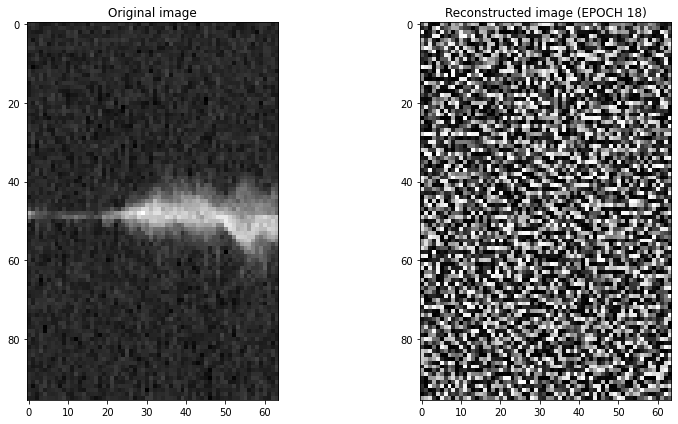

Epoch 19/50, Train Loss: 3049.5824, Validation Loss: 3004.6039


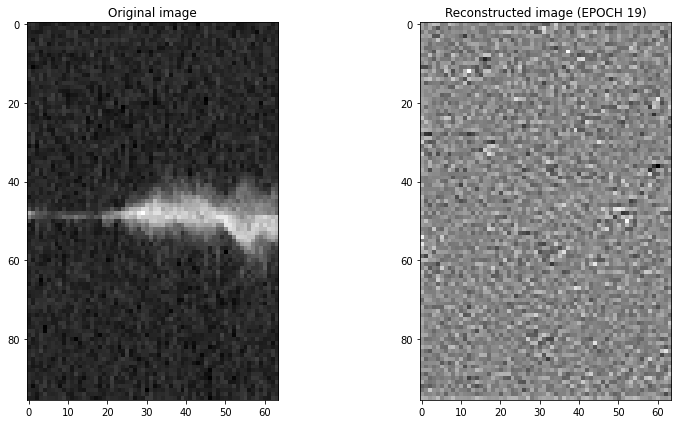

Epoch 20/50, Train Loss: 2970.5523, Validation Loss: 3017.3265


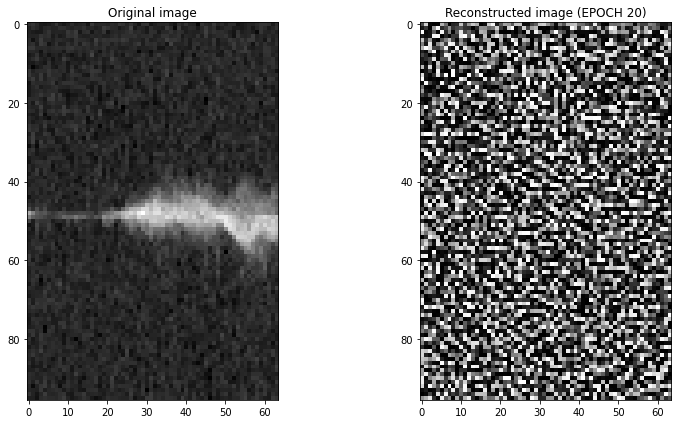

Epoch 21/50, Train Loss: 2894.9347, Validation Loss: 2766.5695


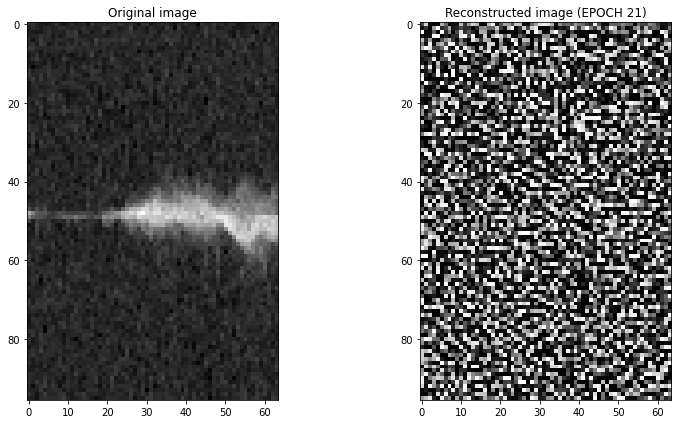

Epoch 22/50, Train Loss: 2822.2708, Validation Loss: 2731.3138


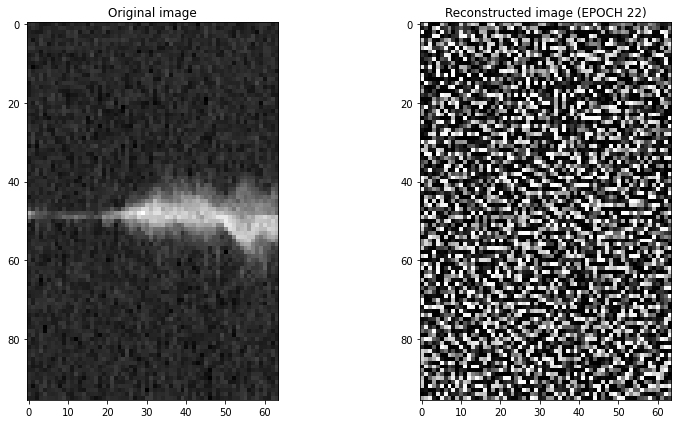

Epoch 23/50, Train Loss: 2746.9566, Validation Loss: 3067.5940


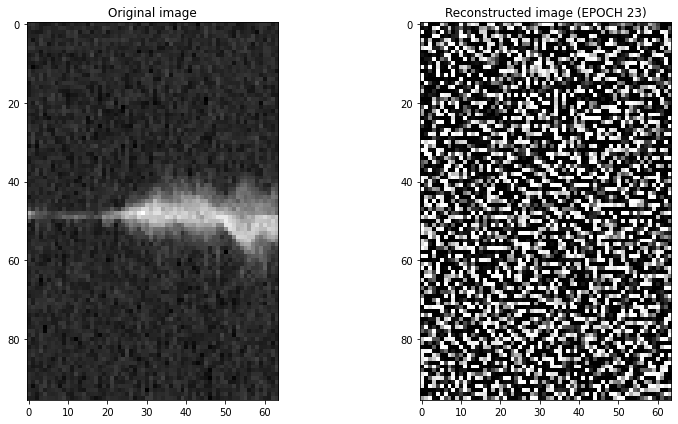

Epoch 24/50, Train Loss: 2674.4943, Validation Loss: 2882.8436


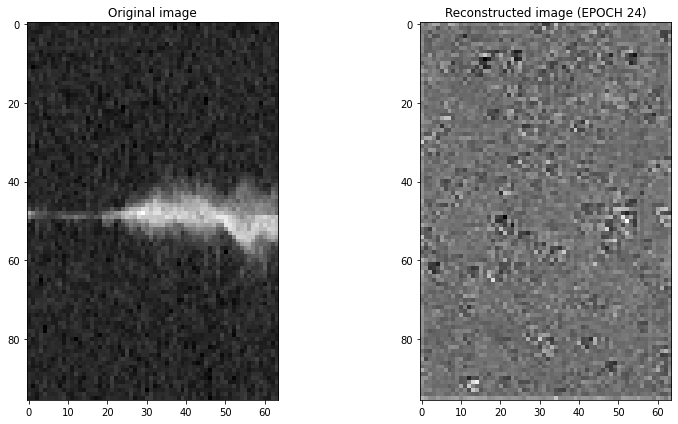

Epoch 25/50, Train Loss: 2604.0436, Validation Loss: 2723.2491


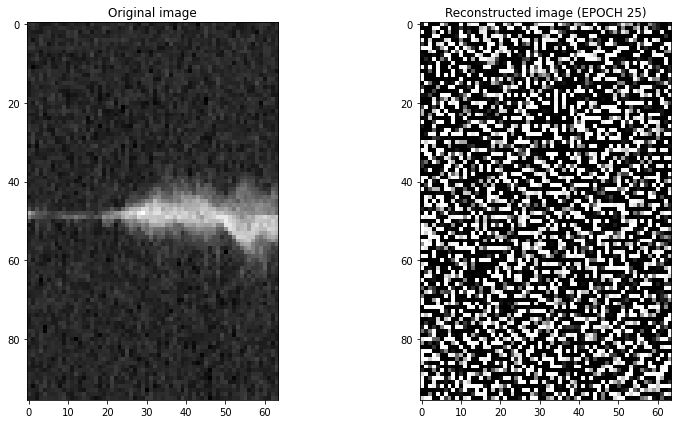

Epoch 26/50, Train Loss: 2540.6546, Validation Loss: 2638.4428


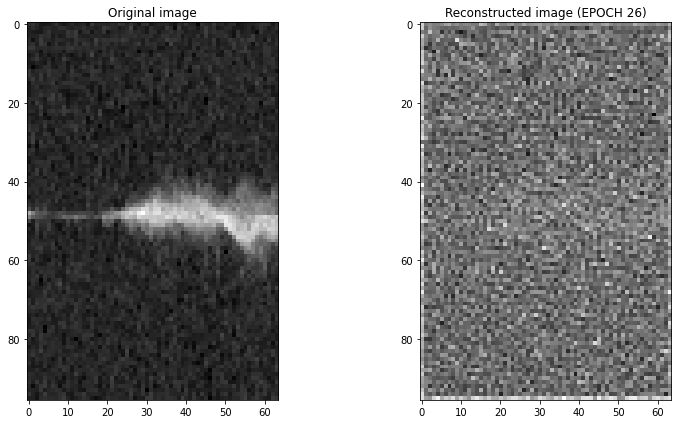

Epoch 27/50, Train Loss: 2481.4105, Validation Loss: 2459.4363


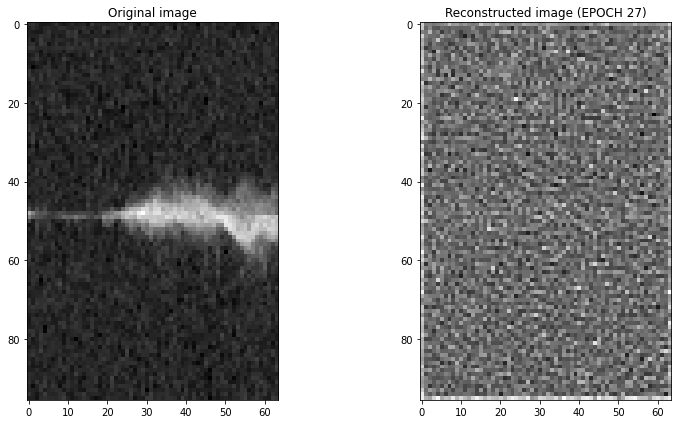

Epoch 28/50, Train Loss: 2418.5611, Validation Loss: 2328.8338


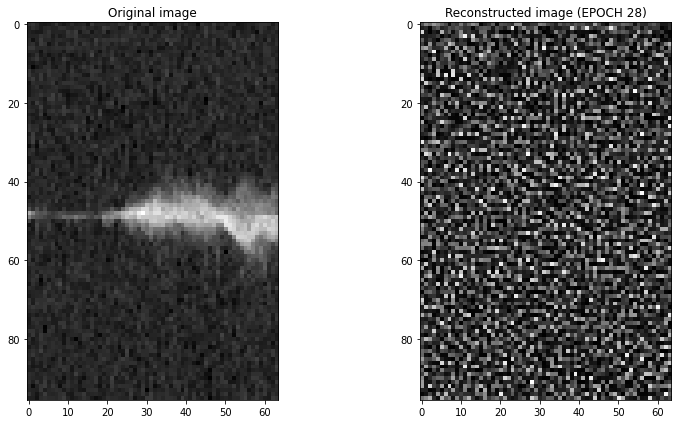

Epoch 29/50, Train Loss: 2361.6433, Validation Loss: 2309.7523


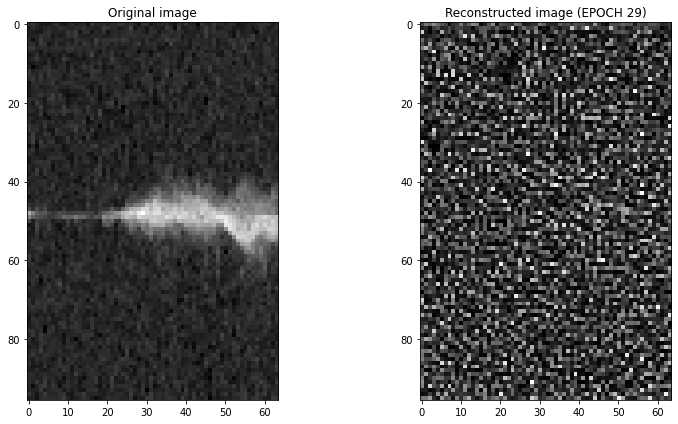

Epoch 30/50, Train Loss: 2299.8063, Validation Loss: 2221.8520


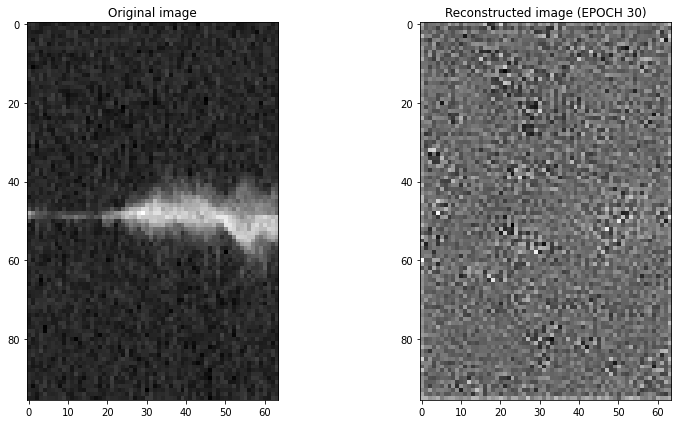

Epoch 31/50, Train Loss: 2244.2718, Validation Loss: 2207.8857


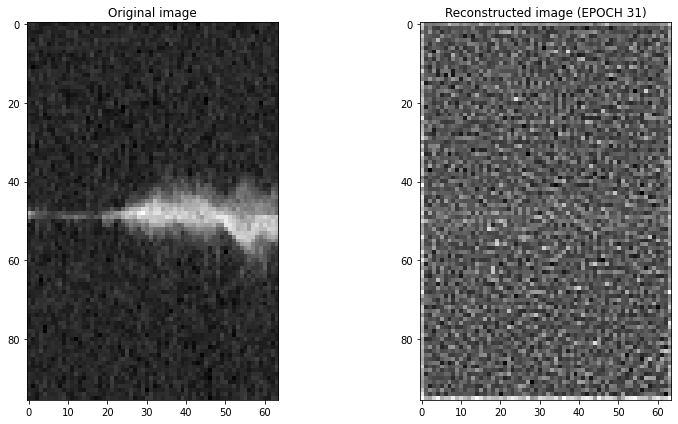

Epoch 32/50, Train Loss: 2188.7744, Validation Loss: 2128.5025


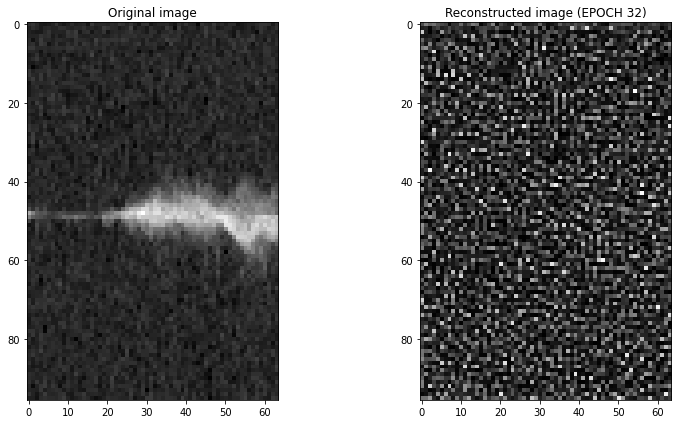

Epoch 33/50, Train Loss: 2150.6834, Validation Loss: 2114.9223


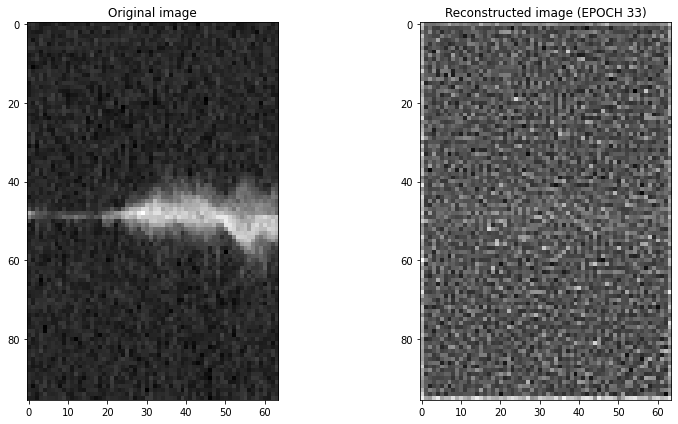

Epoch 34/50, Train Loss: 2100.0088, Validation Loss: 2093.0405


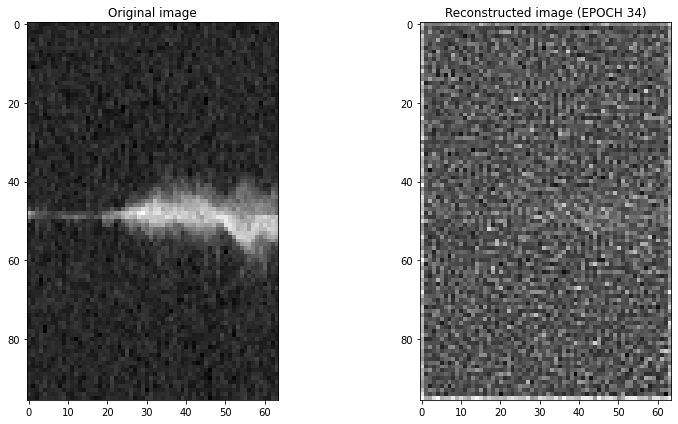

Epoch 35/50, Train Loss: 2052.9230, Validation Loss: 2037.5175


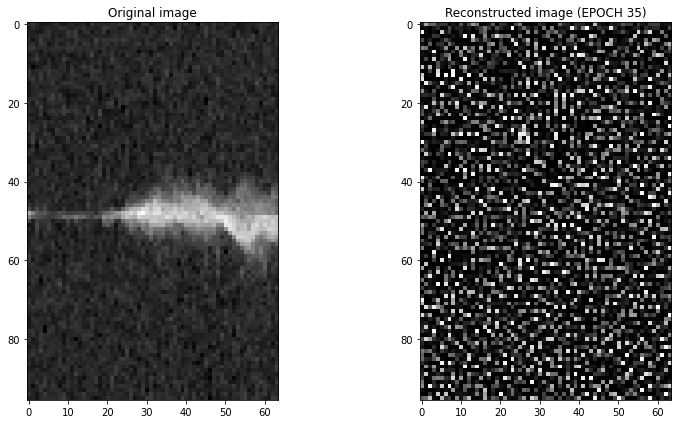

Epoch 36/50, Train Loss: 2015.7158, Validation Loss: 2143.5405


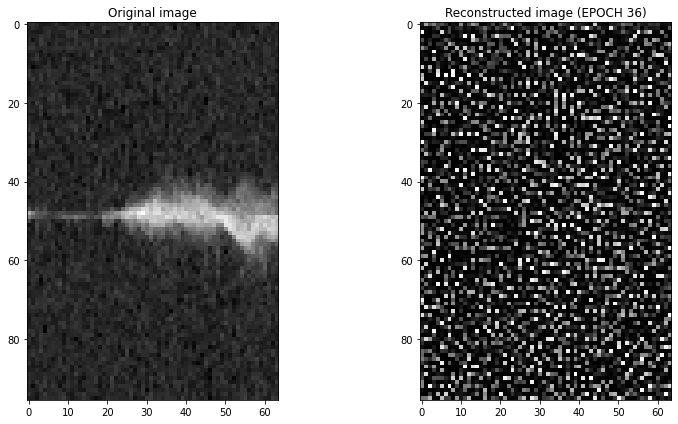

Epoch 37/50, Train Loss: 1981.0303, Validation Loss: 1966.1894


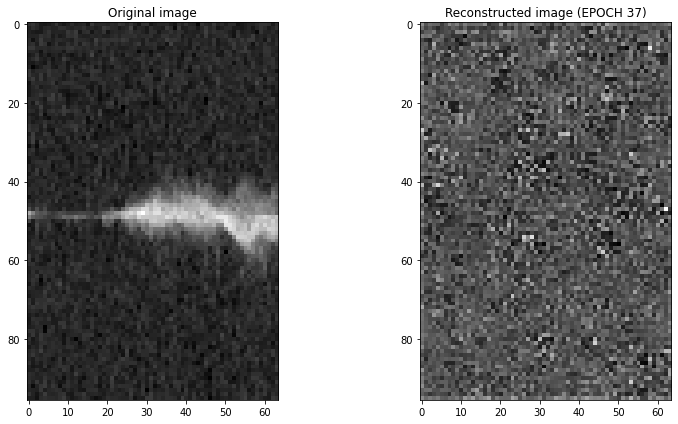

Epoch 38/50, Train Loss: 1942.6330, Validation Loss: 1855.6315


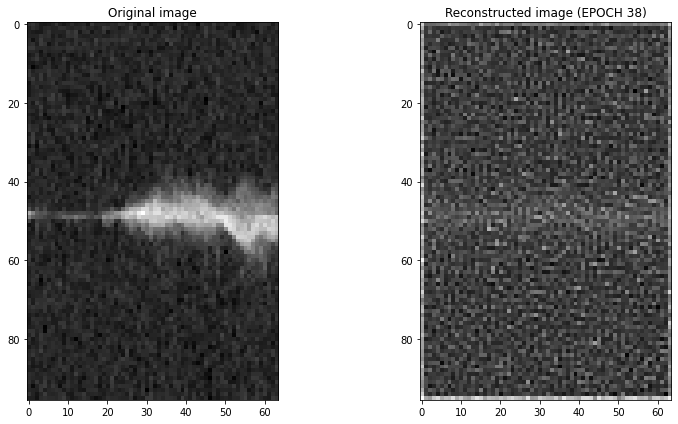

Epoch 39/50, Train Loss: 1903.1215, Validation Loss: 1842.8405


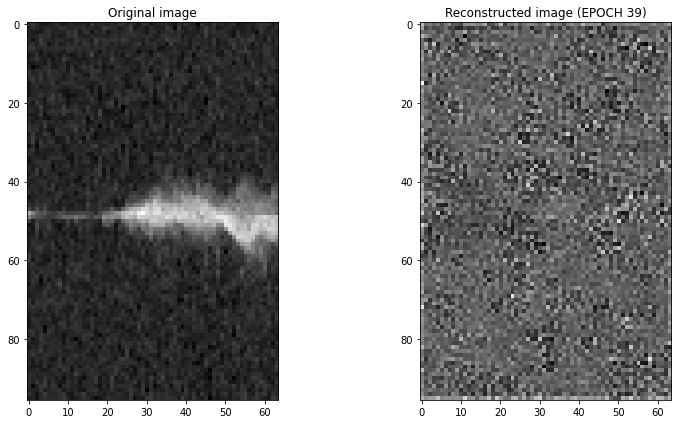

Epoch 40/50, Train Loss: 1872.9344, Validation Loss: 1854.3447


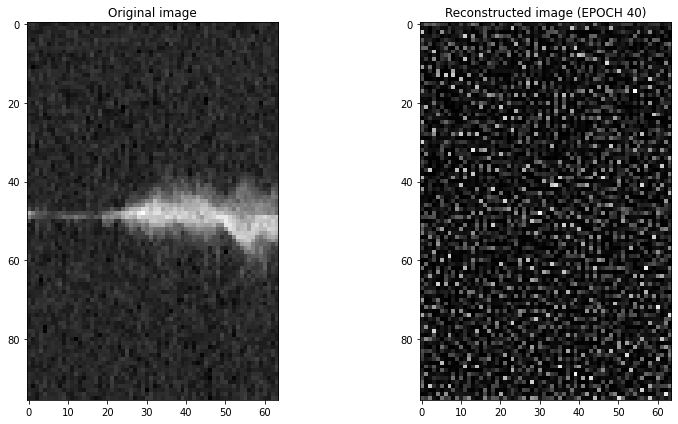

Epoch 41/50, Train Loss: 1843.0595, Validation Loss: 1914.2925


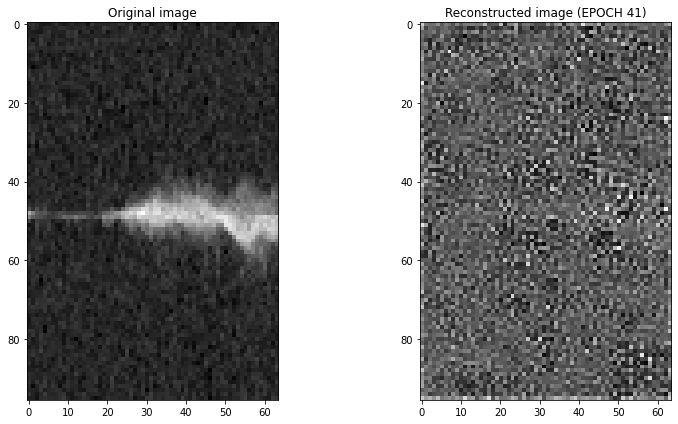

Epoch 42/50, Train Loss: 1810.3555, Validation Loss: 1793.1422


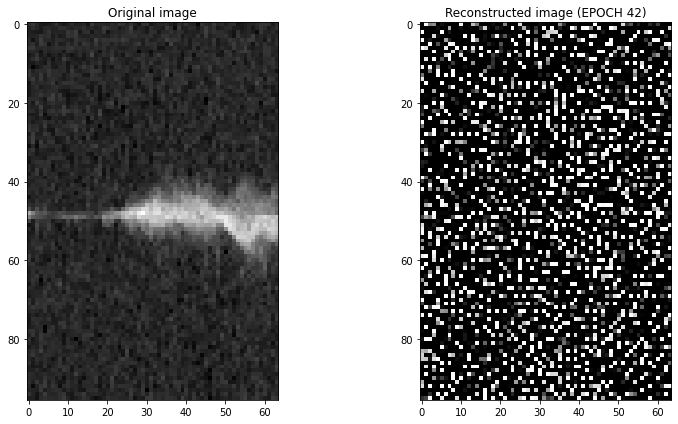

Epoch 43/50, Train Loss: 1786.4841, Validation Loss: 1744.2562


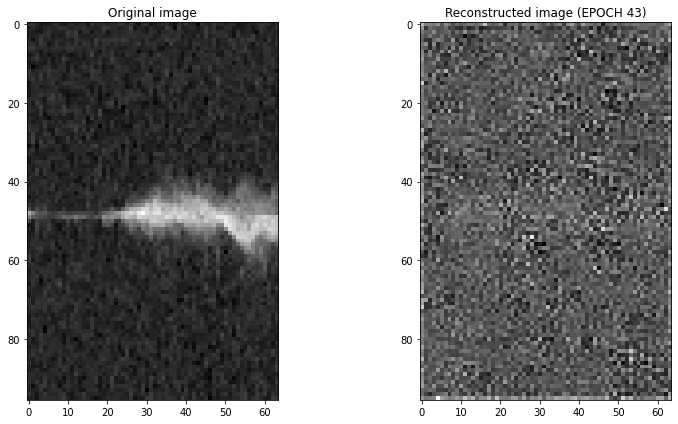

Epoch 44/50, Train Loss: 1761.2985, Validation Loss: 1668.5482


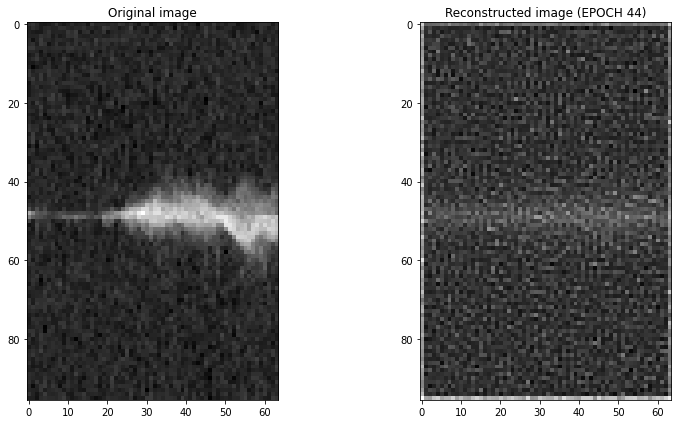

Epoch 45/50, Train Loss: 1739.7412, Validation Loss: 1797.0825


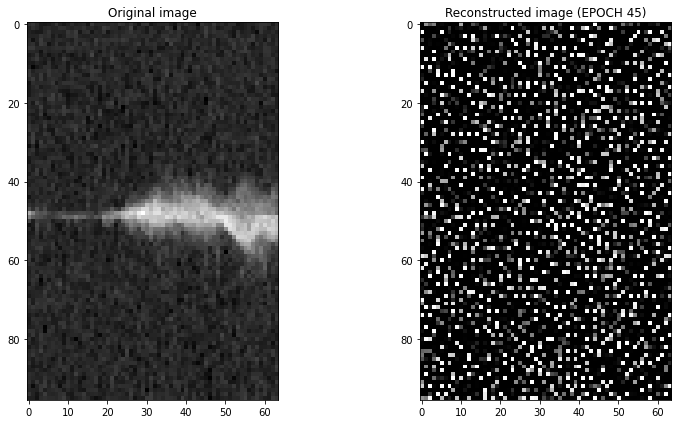

Epoch 46/50, Train Loss: 1719.0681, Validation Loss: 1694.8590


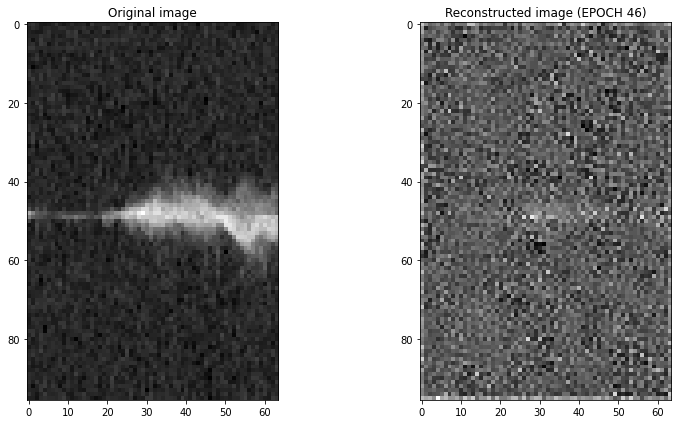

Epoch 47/50, Train Loss: 1698.1355, Validation Loss: 1629.9618


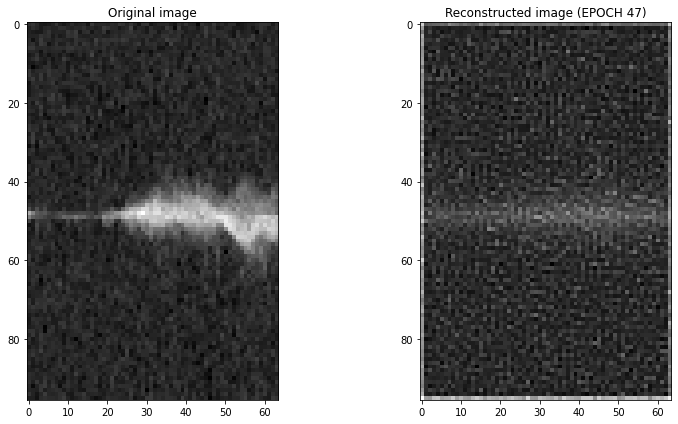

Epoch 48/50, Train Loss: 1683.7743, Validation Loss: 1712.1489


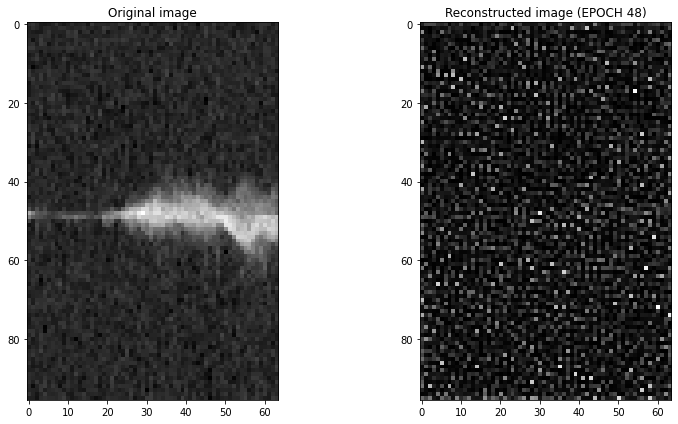

Epoch 49/50, Train Loss: 1670.4578, Validation Loss: 1585.8431


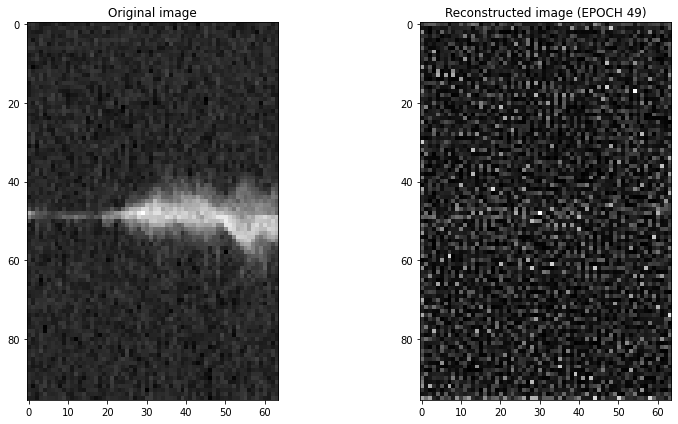

Epoch 50/50, Train Loss: 1650.6426, Validation Loss: 1620.3899


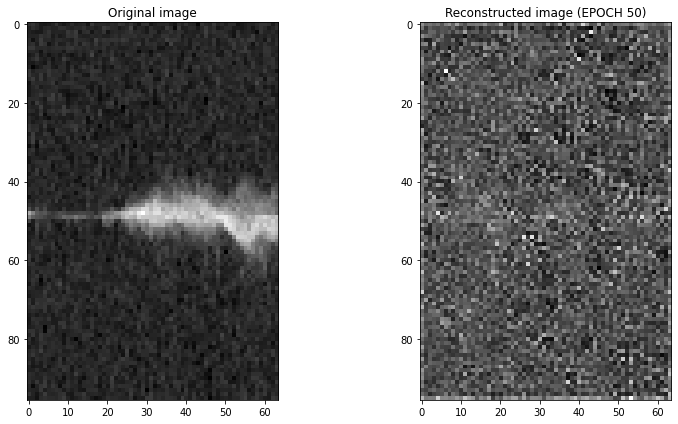

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.apply(weights_init)
model = model.to(device)
trainl, trainrl, trainkl, vall, valrl, valkl = train_vae(model, train_dataloader, val_dataloader, num_epochs=50, device=device)

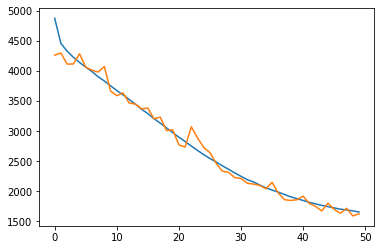

In [9]:
plt.plot(np.arange(50), trainl, label='Training loss')
plt.plot(np.arange(50), vall, label='Validation loss')
plt.show()

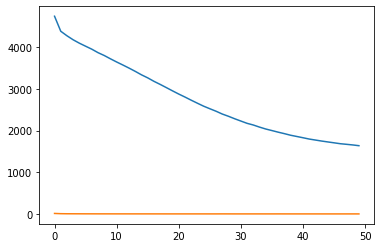

In [10]:
plt.plot(np.arange(50), trainrl, label='Reconstruction')
plt.plot(np.arange(50), trainkl, label='KL divergence')
plt.show()

In [11]:
import pandas as pd
from tqdm import tqdm
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(trainset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.encoder.eval()
    with torch.no_grad():
        encoded_img, _  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.iloc[:,:-1]

100%|██████████| 3899/3899 [00:05<00:00, 773.88it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 22,Enc. Variable 23,Enc. Variable 24,Enc. Variable 25,Enc. Variable 26,Enc. Variable 27,Enc. Variable 28,Enc. Variable 29,Enc. Variable 30,Enc. Variable 31
0,-0.122598,-0.288692,-1.001782,0.622041,-0.500826,-0.083119,0.375377,0.966990,-0.392052,-0.045295,...,-0.924560,-0.933438,-0.269006,0.733707,0.635703,0.415934,0.030549,1.473440,1.096738,0.160968
1,-0.026173,0.058323,0.099241,0.107019,-0.079718,-0.073577,-0.006965,-0.096423,-0.005284,0.007339,...,-0.106144,-0.016800,-0.111555,-0.036111,0.058881,-0.047536,-0.026990,0.069720,-0.045640,-0.010171
2,-0.040199,-0.082141,0.046653,-0.064636,-0.083873,-0.022751,0.072296,-0.046157,-0.086033,0.039355,...,-0.078422,-0.022313,-0.006160,-0.020017,0.006736,0.056975,-0.007106,-0.043569,-0.171280,-0.130849
3,-0.019208,-0.019760,0.098530,-0.023927,0.043004,-0.001170,0.021104,-0.062599,-0.027910,-0.055214,...,0.024959,-0.015359,-0.070339,-0.008612,-0.002692,0.038714,-0.033924,-0.060930,0.114603,0.099483
4,0.022061,0.078660,0.072958,-0.111400,0.014915,0.003465,0.057597,-0.110497,-0.033946,0.102139,...,0.042017,0.186460,-0.057991,-0.172817,-0.087185,-0.011106,0.098475,-0.147774,-0.219432,-0.049737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,-0.010775,0.027839,0.048359,0.000274,0.109257,0.054939,-0.012301,-0.046969,0.063868,0.008264,...,0.047009,0.054423,-0.006894,-0.050994,-0.106756,-0.025539,0.080490,-0.073332,0.006954,-0.036351
3895,0.072499,0.030015,0.080119,-0.022860,0.008714,-0.084126,-0.032819,-0.080241,0.029017,0.060793,...,0.151422,0.175369,-0.089816,-0.043991,-0.055144,-0.094105,0.226802,-0.191438,-0.265925,-0.076059
3896,0.035097,0.058136,0.266934,-0.070250,0.019438,-0.050796,-0.089208,-0.211564,0.055846,0.088992,...,0.047281,0.188236,-0.070932,-0.163297,-0.057392,-0.094178,0.038933,-0.264729,-0.257605,-0.102969
3897,-0.037712,-0.060661,0.039909,-0.058604,0.103829,0.061408,0.018698,0.014843,0.039179,0.061385,...,0.027993,-0.008913,0.009157,-0.020716,-0.022602,-0.032230,-0.000024,-0.095865,-0.006913,0.051811


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples.iloc[:,:-1]) # Result of the PCA over the samples in the latent space
#encoded_samples_reduced_PCA 
print(pca.explained_variance_ratio_ )# Percentage of information provided by each PCA components
print(len(pca.components_[0])) # PCA components 

[0.8564696  0.03052974 0.01192909 0.01062308 0.00969867 0.00752226
 0.00575149 0.00533616 0.00504914 0.00480413]
32


In [13]:
encoded_samples_reduced_PCA

array([[ 4.0472813 , -0.17076425],
       [-0.02684233,  0.14306943],
       [-0.13169037, -0.08645199],
       ...,
       [-0.6106874 ,  0.13566902],
       [-0.08564272,  0.11512684],
       [-0.320762  , -0.13624789]], dtype=float32)

In [14]:
np.unique(encoded_samples.label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [23]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
#from sklearn import svm, datasets


x = encoded_samples_reduced_PCA#[:,0:2]

class_model = SVC(kernel="rbf", gamma = 0.7,C=1.0)

clf = class_model.fit(x, encoded_samples.label)

In [16]:
np.array(encoded_samples.label)[0:5]

array([13, 11,  0,  1,  6])

In [25]:
Z = clf.predict(x)
len(np.where(Z != encoded_samples.label)[0])

2312

In [18]:
unique, counts = np.unique(Z, return_counts=True)
counts

array([  57,  949,  742,  422, 1729])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[ 0  6  9 10 11]


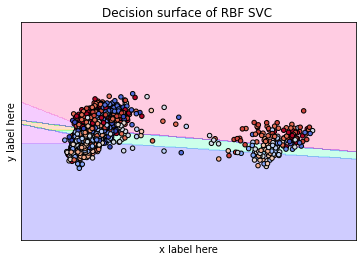

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


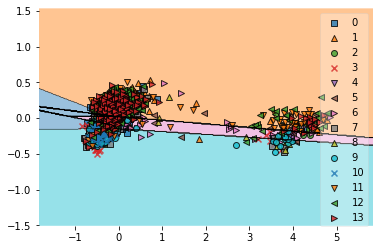

In [19]:
!pip install mlxtend
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mlxtend.plotting import plot_decision_regions


X = x  # we only take the first two features.
y = encoded_samples.label

def make_meshgrid(x, y, h=.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #x_min, x_max = x.min() - 1, x.max() + 1
    #y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    print(np.unique(Z))
  
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of RBF SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)


plot_contours(ax, clf, xx, yy, cmap='hsv', alpha=0.2)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
#ax.legend()
plt.show()

#svm = SVC(C=0.5, kernel='linear')
#svm.fit(X, y)
plot_decision_regions(np.array(X), np.array(y), clf=clf, legend=1)
plt.show()


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


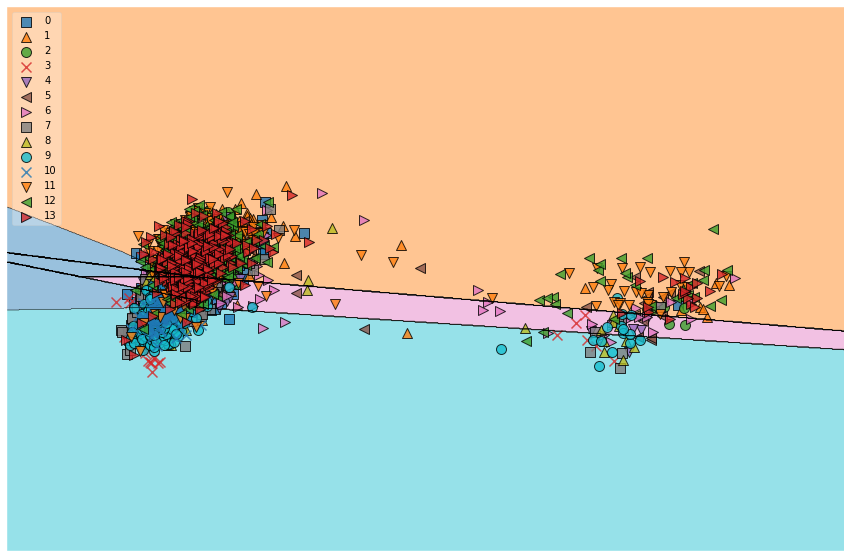

In [20]:
fig = plt.figure(figsize=(15,10))
contour_kwargs = {'linestyles':None}
plot_decision_regions(np.array(X), np.array(y), clf=clf, legend=2,scatter_kwargs={'s':100,'marker':'o'})
plt.axis('off');

In [21]:
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.xlim(xx.min(), xx.max())
    plt.title('SVM Decision Boundary')

plot_decision_boundary(clf, X, y)

ValueError: ignored

In [ ]:
test_encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model.encoder.eval()
    with torch.no_grad():
        encoded_img, _  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    test_encoded_samples.append(encoded_sample)

test_encoded_samples = pd.DataFrame(test_encoded_samples)
test_encoded_samples

In [ ]:
test_encoded_samples_reduced_PCA = pca.transform(test_encoded_samples)

In [ ]:
X = test_encoded_samples_reduced_PCA # we only take the first two features.
y = test_encoded_samples.label

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    print(np.unique(Z))
  
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of RBF SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap='hsv', alpha=0.2)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
#ax.legend()
plt.show()

In [ ]:
Z = clf.predict(x)
np.where(Z != encoded_samples.label)

In [ ]:
import pickle

# save
with open('SVM.pkl','wb') as f:
    pickle.dump(clf,f)

# load
with open('SVM.pkl', 'rb') as f:
    clf2 = pickle.load(f)

clf2.predict(X[0:1])

In [ ]:
import plotly.express as px

In [ ]:
encoded_samples_reduced_PCA[:,0]

In [ ]:
encoded_samples_reduced_PCA = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_PCA[:,0],
    "Enc. Variable 1": encoded_samples_reduced_PCA[:,1], 
    "label":encoded_samples.label}
)
px.scatter(encoded_samples_reduced_PCA, x='Enc. Variable 0', y='Enc. Variable 1', color="label", opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=300)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples.iloc[:,:-1])
encoded_samples_reduced_TSNE = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_TSNE[:, 0],
    "Enc. Variable 1": encoded_samples_reduced_TSNE[:, 1], 
    "label":encoded_samples.label}
)
px.scatter(encoded_samples_reduced_TSNE, x='Enc. Variable 0', y='Enc. Variable 1', color='label', opacity=0.7)

In [ ]:
px.scatter(encoded_samples_reduced_TSNE, x='Enc. Variable 0', y='Enc. Variable 1', color='label', opacity=0.7)